# Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import kagglehub
import string
import re
import pickle

In [3]:
# Download Flickr8k Dataset
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:28<00:00, 38.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


# First Part

In [ ]:
# Image Preprocessing Function
def preprocess_image(img_path, target_size=(299, 299)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Caption Preprocessing Function
def preprocess_captions(captions):
    # Convert to lowercase
    captions = [caption.lower() for caption in captions]

    # Remove special characters
    captions = [re.sub(r'[^a-zA-Z\s]', '', caption) for caption in captions]

    # Add start and end tokens
    captions = ['<start> ' + caption + ' <end>' for caption in captions]

    return captions

In [ ]:
# Tokenization and Vocabulary Creation
def create_tokenizer(captions, max_vocab_size=10000):
    tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Extract features for all images
def extract_features(img_paths):
    features = []
    print("Extracting features for {} images...".format(len(img_paths)))
    for img_path in img_paths:
        img = preprocess_image(img_path)
        feature = base_model.predict(img)
        features.append(feature.flatten())
        print("Extracted features for {} images".format(len(features)))
    return np.array(features)

In [ ]:
# Extract features for images in batches
def extract_features_in_batches(img_paths, batch_size=1000, save_path='image_features.npy'):
    features = []
    total_images = len(img_paths)
    print(f"Extracting features for {total_images} images in batches of {batch_size}...")

    for batch_start in range(0, total_images, batch_size):
        batch_end = min(batch_start + batch_size, total_images)
        batch_paths = img_paths[batch_start:batch_end]
        print(f"Processing batch {batch_start // batch_size + 1} with {len(batch_paths)} images...")

        # Process images in the current batch
        batch_features = []
        for img_path in batch_paths:
            img = preprocess_image(img_path)
            feature = base_model.predict(img, verbose=0)
            batch_features.append(feature.flatten())

        # Append batch features to the main list
        features.append(np.array(batch_features))

    # Concatenate all batches into a single array
    features_array = np.concatenate(features, axis=0)

    # Save the array to a file
    np.save(save_path, features_array)
    print(f"All features extracted and saved to '{save_path}'")

    return features_array


In [ ]:
# Feature Extraction with InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

In [ ]:
# Prepare Dataset
image_paths = [os.path.join(path, "Images", img_name) for img_name in captions_df['image']]
captions = captions_df['caption'].tolist()

# Preprocess Captions
processed_captions = preprocess_captions(captions)
tokenizer = create_tokenizer(processed_captions)
total_words = len(tokenizer.word_index) + 1

# Convert Captions to Sequences
caption_sequences = tokenizer.texts_to_sequences(processed_captions)
max_sequence_length = max(len(seq) for seq in caption_sequences)
padded_sequences = pad_sequences(caption_sequences, maxlen=max_sequence_length, padding='post')

In [ ]:
# Extract Image Features
# image_features = extract_features(image_paths)
# features = extract_features_in_batches(image_paths, batch_size=1000, save_path='image_features.npy')

# Second Part

In [4]:
# Load Captions
captions_file = os.path.join(path, 'captions.txt')
captions_df = pd.read_csv(captions_file)
print("Total Captions:", len(captions_df))

# Parse the captions
captions_df.columns = ['image', 'caption']

# Group captions by image
captions_dict = captions_df.groupby('image')['caption'].apply(list).to_dict()

Total Captions: 40455


**DataGen**

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, features, captions, tokenizer, max_length, vocab_size, batch_size=32, shuffle=True):
        self.features = features
        self.captions = captions
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.features))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.features) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.features))
        batch_indexes = self.indexes[start_idx:end_idx]

        batch_features = self.features[batch_indexes]
        batch_captions = self.captions[batch_indexes]

        X1, X2, y = [], [], []

        for idx, caption in enumerate(batch_captions):
            for i in range(1, len(caption)):
                in_seq = caption[:i]
                out_seq = caption[i]

                # Ensure right-padding for GPU compatibility
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                X1.append(batch_features[idx])
                X2.append(in_seq)
                y.append(out_seq)

        return {'image_input': np.array(X1), 'text_input': np.array(X2)}, np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [11]:
def clean_captions(caption):
    # Remove special characters and digits
    caption = re.sub('[^A-Za-z\s]', '', caption.lower())
    return caption

In [12]:
def preprocess_captions(captions_df):
    # Clean captions
    captions_df['caption'] = captions_df['caption'].str.lower()

    # Add start and end tokens
    captions_df['caption'] = 'startseq ' + captions_df['caption'] + ' endseq'

    # Create tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions_df['caption'])

    # Convert captions to sequences
    sequences = tokenizer.texts_to_sequences(captions_df['caption'])

    # Get vocabulary size and maximum sequence length
    vocab_size = len(tokenizer.word_index) + 1
    max_length = max(len(seq) for seq in sequences)

    # Pad sequences with post padding for GPU compatibility
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    return tokenizer, padded_sequences, vocab_size, max_length

In [13]:
def build_model(vocab_size, max_length, feature_dim=2048, embedding_dim=256, lstm_units=256):
    # Image feature input
    image_input = Input(shape=(feature_dim,), name='image_input')
    fe1 = Dropout(0.3)(image_input)
    fe2 = Dense(embedding_dim, activation='relu')(fe1)

    # Sequence input
    text_input = Input(shape=(max_length,), name='text_input')
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
    se2 = Dropout(0.3)(se1)

    # LSTM layer with cuDNN compatibility settings
    lstm_layer = LSTM(
        lstm_units,
        return_sequences=False,
        # Disable cuDNN if needed
        # use_cudnn=False,  # Uncomment this line if still having issues
        implementation=2,  # Implementation 2 is more efficient for GPU
        recurrent_activation='sigmoid',  # Required for cuDNN
        activation='tanh'  # Required for cuDNN
    )
    decoder1 = lstm_layer(se2)
    decoder2 = Dropout(0.3)(decoder1)

    # Merge inputs
    decoder3 = tf.keras.layers.Add()([decoder2, fe2])

    # Decoder output
    outputs = Dense(vocab_size, activation='softmax')(decoder3)

    # Create model
    model = Model(inputs={'image_input': image_input, 'text_input': text_input}, outputs=outputs)

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [ ]:
# Main execution
print("Loading features...")
features = np.load('/content/drive/MyDrive/image_features.npy')

print("Preprocessing captions...")
tokenizer, padded_sequences, vocab_size, max_length = preprocess_captions(captions_df)

# Split data
split_idx = int(len(features) * 0.8)
train_features = features[:split_idx]
val_features = features[split_idx:]
train_captions = padded_sequences[:split_idx]
val_captions = padded_sequences[split_idx:]

# Create generators
batch_size = 16
train_generator = DataGenerator(
    train_features,
    train_captions,
    tokenizer,
    max_length,
    vocab_size,
    batch_size=batch_size
)
val_generator = DataGenerator(
    val_features,
    val_captions,
    tokenizer,
    max_length,
    vocab_size,
    batch_size=batch_size
)

# Build and train model
model = build_model(vocab_size, max_length)

# Train with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Loading features...
Preprocessing captions...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2023/2023 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7639 - loss: 1.5338

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2023/2023 ━━━━━━━━━━━━━━━━━━━━ 334s 162ms/step - accuracy: 0.7639 - loss: 1.5337 - val_accuracy: 0.8022 - val_loss: 1.0306
Epoch 2/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 322s 159ms/step - accuracy: 0.8067 - loss: 0.9566 - val_accuracy: 0.8087 - val_loss: 0.9766
Epoch 3/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 351s 144ms/step - accuracy: 0.8149 - loss: 0.8578 - val_accuracy: 0.8098 - val_loss: 0.9639
Epoch 4/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 280s 123ms/step - accuracy: 0.8200 - loss: 0.7965 - val_accuracy: 0.8107 - val_loss: 0.9682
Epoch 5/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 271s 127ms/step - accuracy: 0.8246 - loss: 0.7505 - val_accuracy: 0.8104 - val_loss: 0.9731
Epoch 6/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 257s 127ms/step - accuracy: 0.8281 - loss: 0.7215 - val_accuracy: 0.8112 - val_loss: 0.9764
Epoch 7/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 260s 128ms/step - accuracy: 0.8314 - loss: 0.6986 - val_accuracy: 0.8118 - val_loss: 0.9801
Epoch 8/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 254s 124ms/step - accuracy: 0.8

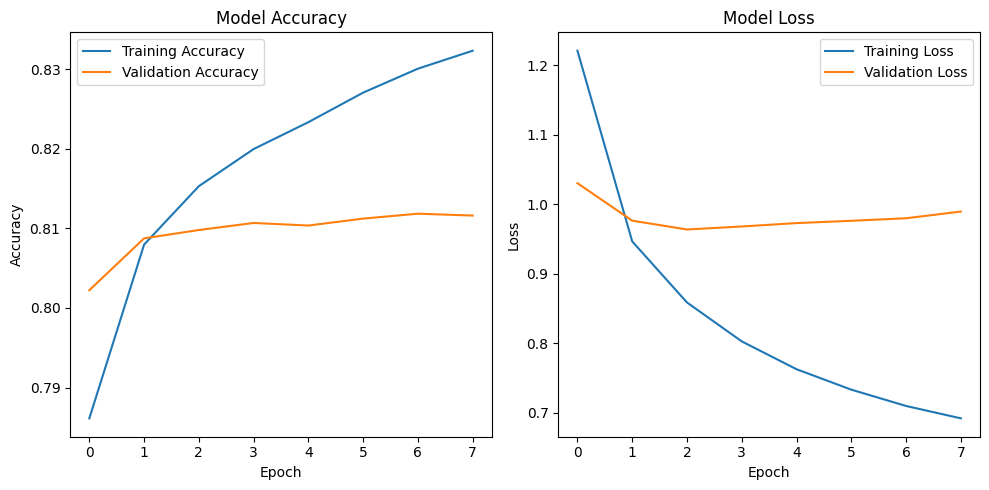

In [ ]:
# Plot training history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2
import matplotlib.image as mpimg
from nltk.translate.bleu_score import corpus_bleu

base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

def preprocess_image(img_path, target_size=(299, 299)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def extract_features(img_array):
    feature = base_model.predict(img_array)
    return feature

def generate_caption(model, image_features, tokenizer, max_length=39):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = next((word for word, index in tokenizer.word_index.items() if index == yhat), None)
        if word is None or word == '<end>':
            break
        in_text += ' ' + word
    return in_text.replace('<start>', '').replace('<end>', '').strip()

def real_time_caption(model, tokenizer, max_length=40):
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img = cv2.resize(frame, (299, 299))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = np.expand_dims(img, axis=0)
        img_array = preprocess_input(img_array)
        features = extract_features(img_array)
        caption = generate_caption(model, features, tokenizer, max_length)
        cv2.putText(frame, caption, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('Image Captioning', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


def evaluate_model(model, test_data, tokenizer, max_length=40):
    """Evaluate model using BLEU scores"""
    actual, predicted = [], []

    for image_features, captions in test_data:
        # Generate caption
        pred_caption = generate_caption(model, image_features, tokenizer, max_length)

        # Prepare actual captions for BLEU score calculation
        actual_captions = []
        for cap in captions:
            actual_caption = ' '.join([idx_to_word(idx, tokenizer) for idx in cap if idx > 0])
            actual_captions.append(actual_caption.split())

        actual.append(actual_captions)
        predicted.append(pred_caption.split())

    # Calculate BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {
        'BLEU-1': bleu1 * 100,
        'BLEU-2': bleu2 * 100,
        'BLEU-3': bleu3 * 100,
        'BLEU-4': bleu4 * 100
    }

# Function to display an image
def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Remove axes for better display
    plt.show()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Load model and tokenizer
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.keras')

with open('/content/drive/MyDrive/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


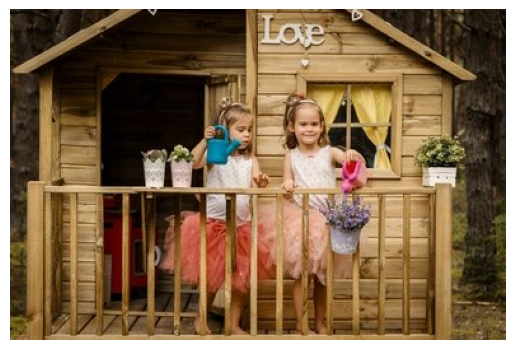

front of a brick building endseq


In [ ]:
# Example usage for single image
features = extract_features(preprocess_image('/content/two-lovely-girls-play-watering-260nw-700342633.jpg'))
caption = generate_caption(model, features, tokenizer, max_length=39)
display_image('/content/two-lovely-girls-play-watering-260nw-700342633.jpg')
print(caption)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


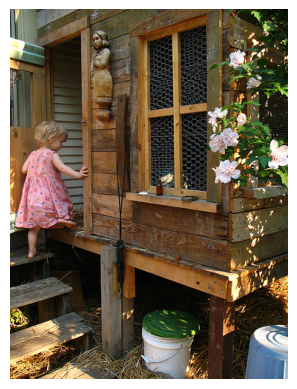

entry a wooden playhouse endseq


In [ ]:
features = extract_features(preprocess_image('/content/1000268201_693b08cb0e.jpg'))
caption = generate_caption(model, features, tokenizer, max_length=39)
display_image('/content/1000268201_693b08cb0e.jpg')
print(caption)